In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [2]:

df = pd.read_csv('/Users/philippevannson/Desktop/stats/games.csv')

In [3]:
df.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2021-05-26  42000102            Final    1610612755       1610612764   
1    2021-05-26  42000132            Final    1610612752       1610612737   
2    2021-05-26  42000142            Final    1610612762       1610612763   
3    2021-05-25  42000112            Final    1610612751       1610612738   
4    2021-05-25  42000152            Final    1610612756       1610612747   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2020    1610612755     120.0        0.557        0.684  ...      26.0   
1    2020    1610612752     101.0        0.383        0.739  ...      15.0   
2    2020    1610612762     141.0        0.544        0.774  ...      28.0   
3    2020    1610612751     130.0        0.523        0.955  ...      31.0   
4    2020    1610612756     102.0        0.465        0.933  ...      21.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  \
0      45.0    1610612764      95.0        0.402        0.633         0.091   
1      54.0    1610612737      92.0        0.369        0.818         0.273   
2      42.0    1610612763     129.0        0.541        0.763         0.348   
3      46.0    1610612738     108.0        0.424        0.783         0.353   
4      31.0    1610612747     109.0        0.450        0.871         0.303   

   AST_away  REB_away  HOME_TEAM_WINS  
0      22.0      40.0               1  
1      17.0      41.0               1  
2      20.0      33.0               1  
3      23.0      43.0               1  
4      24.0      39.0               0  

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24677 entries, 0 to 24676
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     24677 non-null  object 
 1   GAME_ID           24677 non-null  int64  
 2   GAME_STATUS_TEXT  24677 non-null  object 
 3   HOME_TEAM_ID      24677 non-null  int64  
 4   VISITOR_TEAM_ID   24677 non-null  int64  
 5   SEASON            24677 non-null  int64  
 6   TEAM_ID_home      24677 non-null  int64  
 7   PTS_home          24578 non-null  float64
 8   FG_PCT_home       24578 non-null  float64
 9   FT_PCT_home       24578 non-null  float64
 10  FG3_PCT_home      24578 non-null  float64
 11  AST_home          24578 non-null  float64
 12  REB_home          24578 non-null  float64
 13  TEAM_ID_away      24677 non-null  int64  
 14  PTS_away          24578 non-null  float64
 15  FG_PCT_away       24578 non-null  float64
 16  FT_PCT_away       24578 non-null  float6

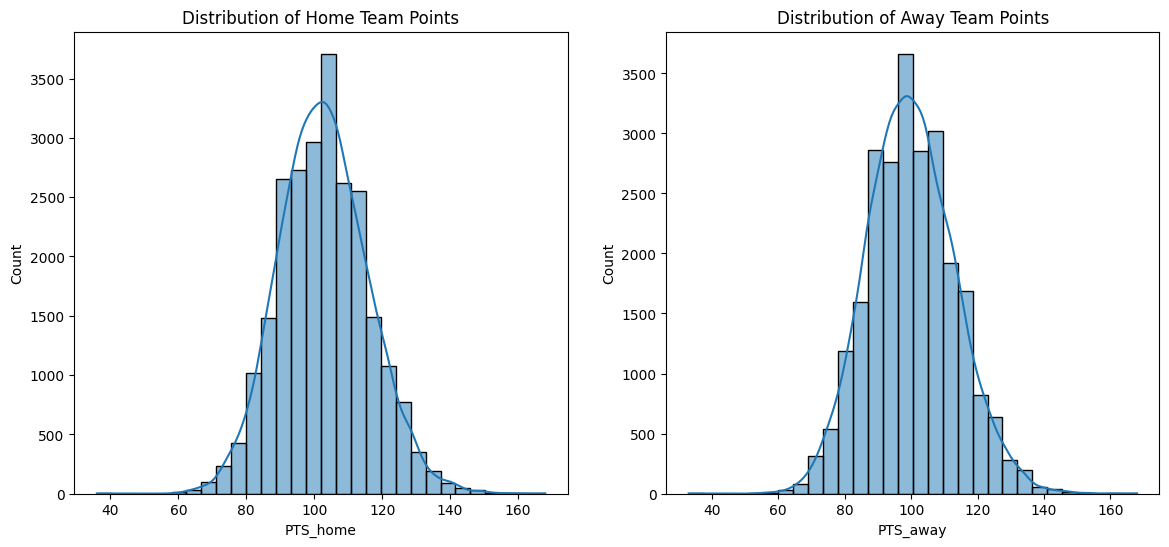

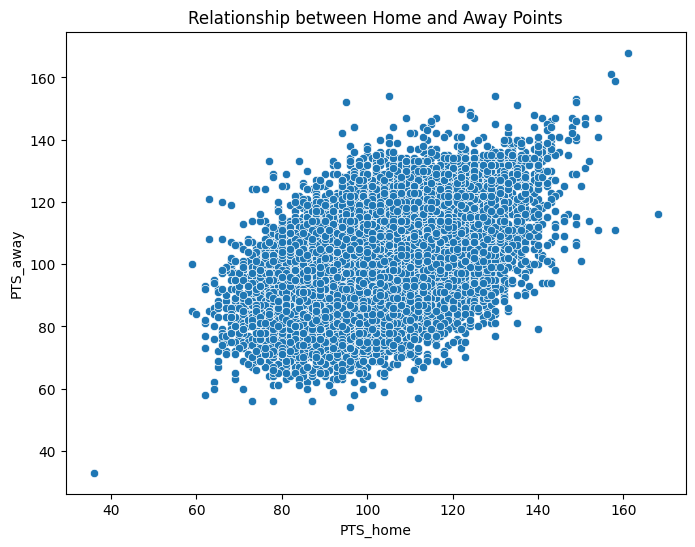

In [5]:
# Visualizing the distribution of points scored by home and away teams
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['PTS_home'], bins=30, kde=True)
plt.title('Distribution of Home Team Points')

plt.subplot(1, 2, 2)
sns.histplot(df['PTS_away'], bins=30, kde=True)
plt.title('Distribution of Away Team Points')

plt.show()

# Scatter plot to explore relationship between home and away points
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PTS_home', y='PTS_away', data=df)
plt.title('Relationship between Home and Away Points')
plt.show()


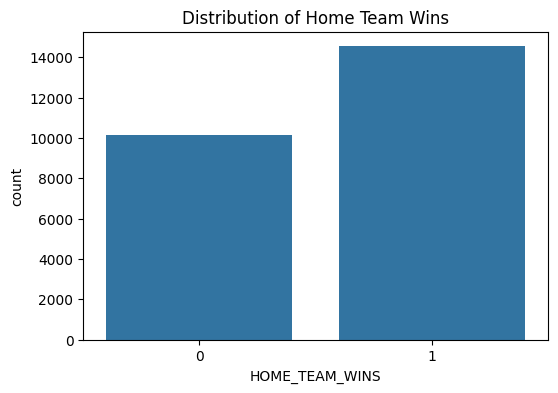

In [6]:
# Distribution of home team wins
plt.figure(figsize=(6, 4))
sns.countplot(x='HOME_TEAM_WINS', data=df)
plt.title('Distribution of Home Team Wins')
plt.show()


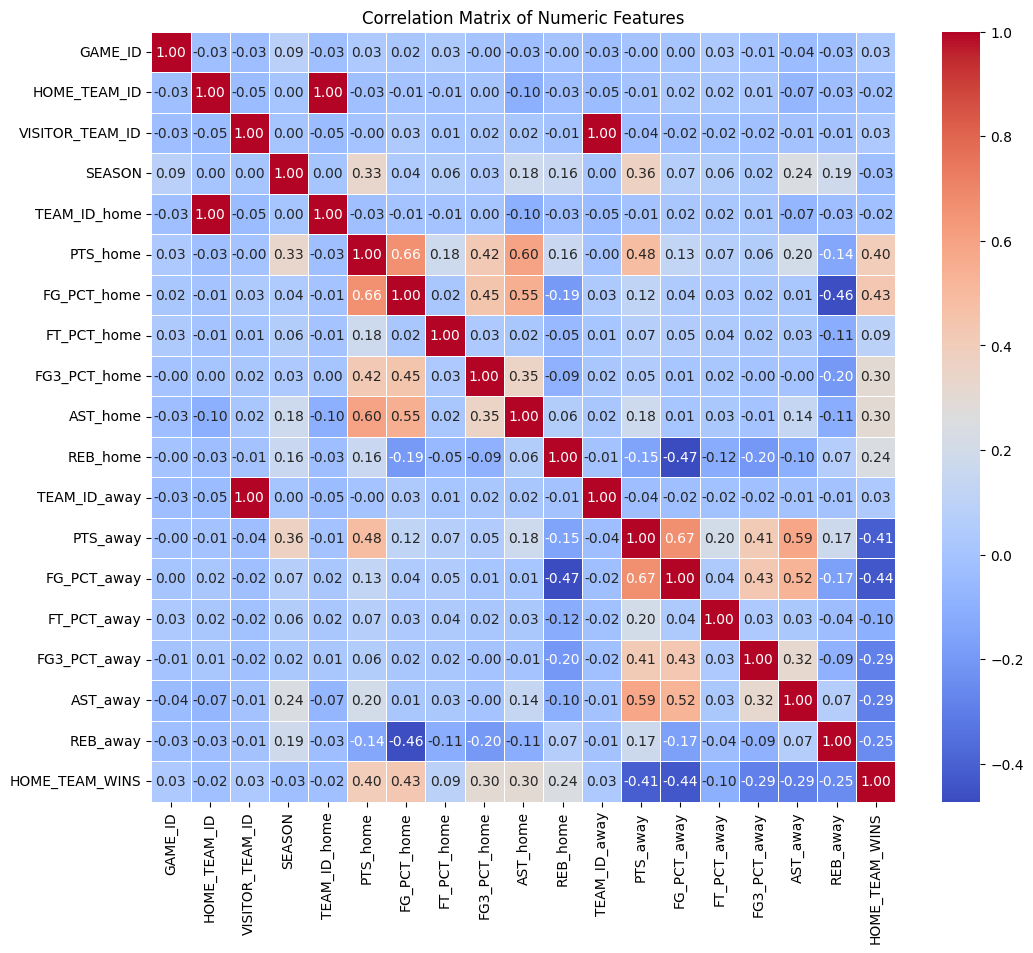

In [38]:
numeric_data = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

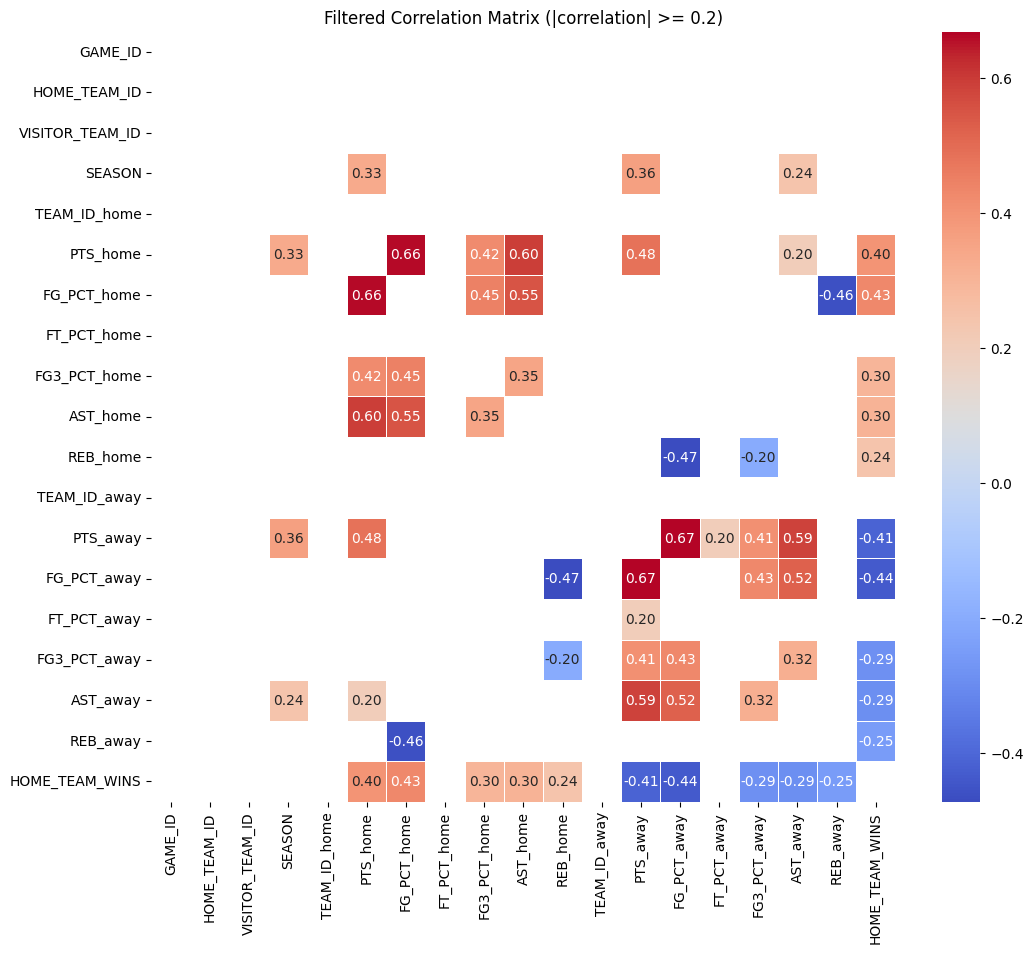

In [41]:
filtered_correlation_matrix = correlation_matrix[(correlation_matrix.abs() >= 0.2) & (correlation_matrix != 1.0)]

# Plot the filtered correlation matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Filtered Correlation Matrix (|correlation| >= 0.2)')
plt.show()

In [45]:
# Calculate rolling averages for each team
def calculate_rolling_averages(data, team_id_col, metrics, window=5):
    rolling_averages = data.groupby(team_id_col)[metrics].rolling(window, min_periods=1).mean().reset_index()
    for metric in metrics:
        rolling_averages.rename(columns={metric: f'{metric}_rolling_avg'}, inplace=True)
    return rolling_averages

# Define the metrics to calculate rolling averages for
metrics = ['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
           'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

# Calculate rolling averages for home team
home_rolling_averages = calculate_rolling_averages(data, 'TEAM_ID_home', metrics)

# Calculate rolling averages for away team
away_rolling_averages = calculate_rolling_averages(data, 'TEAM_ID_away', metrics)

# Merge the rolling averages with the original dataset
data = df.merge(home_rolling_averages, on=['level_0', 'TEAM_ID_home'], how='left')
data = df.merge(away_rolling_averages, on=['level_0', 'TEAM_ID_away'], how='left')

# Drop unnecessary columns after merging
data.drop(columns=['level_0_x', 'level_0_y'], inplace=True)

# Display the first few rows of the dataset to verify
data.head()

NameError: name 'data' is not defined

In [43]:

# Extract the correlations with the target variable
correlation_with_target = correlation_matrix['HOME_TEAM_WINS'].sort_values(ascending=False)
correlation_with_target

HOME_TEAM_WINS     1.000000
FG_PCT_home        0.430994
PTS_home           0.400340
AST_home           0.303739
FG3_PCT_home       0.298675
REB_home           0.244714
FT_PCT_home        0.092117
GAME_ID            0.033471
VISITOR_TEAM_ID    0.030589
TEAM_ID_away       0.030589
TEAM_ID_home      -0.021147
HOME_TEAM_ID      -0.021147
SEASON            -0.025079
FT_PCT_away       -0.104784
REB_away          -0.251432
FG3_PCT_away      -0.288661
AST_away          -0.294234
PTS_away          -0.414046
FG_PCT_away       -0.435208
Name: HOME_TEAM_WINS, dtype: float64

In [21]:
data_cleaned = df.drop(columns=['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID_home', 'TEAM_ID_away'])
data_cleaned.fillna(data_cleaned.mean(), inplace=True)
print(data_cleaned.isnull().sum())

SEASON            0
PTS_home          0
FG_PCT_home       0
FT_PCT_home       0
FG3_PCT_home      0
AST_home          0
REB_home          0
PTS_away          0
FG_PCT_away       0
FT_PCT_away       0
FG3_PCT_away      0
AST_away          0
REB_away          0
HOME_TEAM_WINS    0
dtype: int64


In [44]:
# Define features and target variable
X = data_cleaned.drop(columns='HOME_TEAM_WINS')
y = data_cleaned['HOME_TEAM_WINS']
X

SEASON  PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  \
0        2020     120.0        0.557        0.684         0.429      26.0   
1        2020     101.0        0.383        0.739         0.364      15.0   
2        2020     141.0        0.544        0.774         0.487      28.0   
3        2020     130.0        0.523        0.955         0.447      31.0   
4        2020     102.0        0.465        0.933         0.308      21.0   
...       ...       ...          ...          ...           ...       ...   
24672    2014      93.0        0.419        0.821         0.421      24.0   
24673    2014      81.0        0.338        0.719         0.381      18.0   
24674    2014      98.0        0.448        0.682         0.500      29.0   
24675    2014      99.0        0.440        0.771         0.333      21.0   
24676    2014      86.0        0.431        0.679         0.333      18.0   

       REB_home  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  \
0          45.0      95.0        0.402        0.633         0.091      22.0   
1          54.0      92.0        0.369        0.818         0.273      17.0   
2          42.0     129.0        0.541        0.763         0.348      20.0   
3          46.0     108.0        0.424        0.783         0.353      23.0   
4          31.0     109.0        0.450        0.871         0.303      24.0   
...         ...       ...          ...          ...           ...       ...   
24672      50.0      87.0        0.366        0.643         0.375      17.0   
24673      40.0      85.0        0.411        0.636         0.267      17.0   
24674      45.0      95.0        0.387        0.659         0.500      19.0   
24675      30.0      94.0        0.469        0.725         0.385      18.0   
24676      42.0      98.0        0.462        0.706         0.438      19.0   

       REB_away  
0          40.0  
1          41.0  
2          33.0  
3          43.0  
4          39.0  
...         ...  
24672      43.0  
24673      47.0  
24674      43.0  
24675      45.0  
24676      42.0  

[24677 rows x 13 columns]

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19741, 13) (4936, 13) (19741,) (4936,)


Random Forest Accuracy: 0.9775


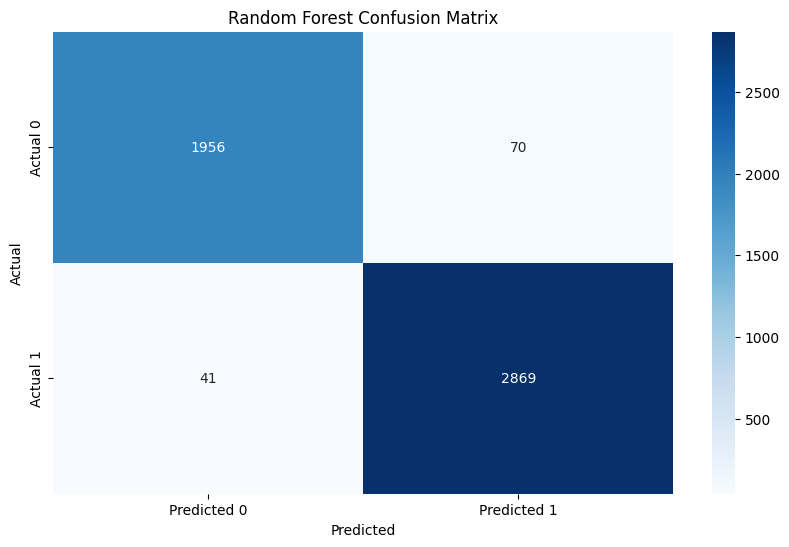

In [33]:
# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


# Random Forest model evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print the evaluation results
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
#print("\nRandom Forest Classification Report:\n")
#print(classification_report_rf)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression Accuracy: 0.9953

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2026
           1       0.99      1.00      1.00      2910

    accuracy                           1.00      4936
   macro avg       1.00      0.99      1.00      4936
weighted avg       1.00      1.00      1.00      4936



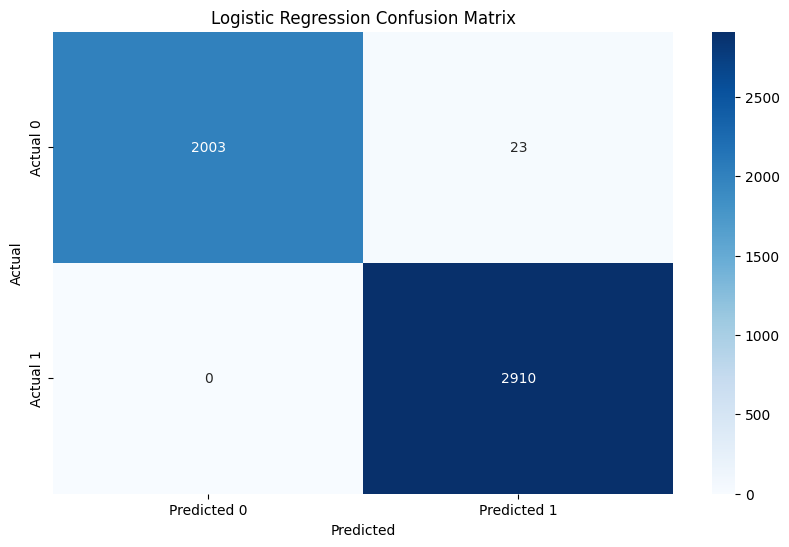

In [36]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_report_lr = classification_report(y_test, y_pred_lr)
confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Print the evaluation results for Logistic Regression
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print("\nLogistic Regression Classification Report:\n")
print(classification_report_lr)

# Plot the confusion matrix for Logistic Regression using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()